<h1>Data Cleaning</h1>

<h3>Import Libraries and Load data</h3>

In [ ]:
%pip install xgboost implicit hyperopt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from implicit.als import AlternatingLeastSquares
# from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, Trials
import implicit

df = pd.read_csv("Amazon-Products.csv")

In [ ]:
df

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990"
1,1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990"
2,2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990"
3,3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990"
4,4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790"
...,...,...,...,...,...,...,...,...,...,...
551580,1099,Adidas Regular Fit Men's Track Tops,sports & fitness,Yoga,https://m.media-amazon.com/images/I/71tHAR9pIY...,https://www.amazon.in/Adidas-Regular-Mens-Trac...,3.2,9,"₹3,449","₹4,599"
551581,1100,Redwolf Noice Toit Smort - Hoodie (Black),sports & fitness,Yoga,https://m.media-amazon.com/images/I/41pKrMZ5lQ...,https://www.amazon.in/Redwolf-Noice-Smort-Cott...,2.0,2,"₹1,199","₹1,999"
551582,1101,Redwolf Schrute Farms B&B - Hoodie (Navy Blue),sports & fitness,Yoga,https://m.media-amazon.com/images/I/41n9u+zNSc...,https://www.amazon.in/Redwolf-Schrute-Farms-Ho...,4.0,1,"₹1,199","₹1,999"
551583,1102,Puma Men Shorts,sports & fitness,Yoga,https://m.media-amazon.com/images/I/51LoWv5JDt...,https://www.amazon.in/Puma-Woven-Short-5208526...,4.4,37,NaN,NaN


Removing first column

In [ ]:
df = df.iloc[:, 1:]
df = df.drop(columns=["image", "link"])

In [ ]:
df.columns

Index(['name', 'main_category', 'sub_category', 'ratings', 'no_of_ratings',
       'discount_price', 'actual_price'],
      dtype='object')

Info of data

In [ ]:
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum(), "\n")

(551585, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551585 entries, 0 to 551584
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            551585 non-null  object
 1   main_category   551585 non-null  object
 2   sub_category    551585 non-null  object
 3   ratings         375791 non-null  object
 4   no_of_ratings   375791 non-null  object
 5   discount_price  490422 non-null  object
 6   actual_price    533772 non-null  object
dtypes: object(7)
memory usage: 29.5+ MB
None
                         name main_category  sub_category ratings  \
count                  551585        551585        551585  375791   
unique                 396210            20           112      49   
top     Zeya Yellow Gold Ring   accessories  Formal Shoes     4.0   
freq                      718        116141         19200   36609   

       no_of_ratings discount_price actual_price  
count         375791         4

Data Cleaning

In [ ]:
print(f"Unique values of ratings:\n{df['ratings'].unique()}")
print(f"Unique values of no_of_ratings:\n{df['no_of_ratings'].unique()}")

Unique values of ratings:
['4.2' '4.0' '4.1' '4.3' '3.9' '3.8' '3.5' nan '4.6' '3.3' '3.4' '3.7'
 '2.9' '5.0' '4.4' '3.6' '2.7' '4.5' '3.0' '3.1' '3.2' '4.8' '4.7' '2.5'
 '1.0' '2.6' '2.8' '2.3' '1.7' 'Get' '1.8' '2.4' '4.9' '2.2' '1.6' '1.9'
 '2.0' '1.4' '2.1' 'FREE' '1.2' '1.3' '1.5' '₹68.99' '₹65' '1.1' '₹70'
 '₹100' '₹99' '₹2.99']
Unique values of no_of_ratings:
['2,255' '2,948' '1,206' ... '3,329' '7,141' '4,406']


In [ ]:
df['no_of_ratings'] = df['no_of_ratings'].str.replace(",","")
df['no_of_ratings'] = pd.to_numeric(df['no_of_ratings'], errors="coerce", downcast="integer")

In [ ]:
# Identifying string in column based on regex and replacing with default ratings -> 3.0
df = df.replace({
    'ratings': {r'₹\w+[.]\w+':'3.0', r'FREE':'3.0', r'Get':'3.0', r'₹\w+':'3.0'},
}, regex=True)
# convert price and discount column to integer
df['actual_price'] = pd.to_numeric(df['actual_price'].str.replace("₹","").str.replace(",",""), errors='coerce', downcast='integer')
df['discount_price'] = pd.to_numeric(df['discount_price'].str.replace("₹","").str.replace(",",""), errors='coerce', downcast='integer')

In [ ]:
df['ratings'] = pd.to_numeric(df['ratings'],errors='coerce',downcast='float')

In [ ]:
df['main_category'].value_counts()

,count
main_category,
accessories,116141
men's clothing,76656
women's clothing,76512
"tv, audio & cameras",68659
men's shoes,57456
appliances,33096
stores,32903
home & kitchen,14568
kids' fashion,13488


Imbalanced data so using CBF, Item based CF, Matrix Factorization (SVD, ALS, NMF) models and feeding it to ensemble method XGBoost.
but before that we should handle missing values

Handling Missing values

In [ ]:
df.isna().sum()

,0
name,0
main_category,0
sub_category,0
ratings,175794
no_of_ratings,182027
discount_price,61163
actual_price,17813


In [ ]:
missing_percentage = (df.isna().sum() / len(df)) * 100
print(missing_percentage)

name               0.000000
main_category      0.000000
sub_category       0.000000
ratings           31.870700
no_of_ratings     33.000716
discount_price    11.088590
actual_price       3.229421
dtype: float64


In [ ]:
df['ratings'].fillna(round(df['ratings'].mean(),1), inplace=True)
df['no_of_ratings'].fillna(round(df['no_of_ratings'].mean()), inplace=True)
mean_actual_price_by_sub_category = round(df.groupby('sub_category')[['actual_price','discount_price']].mean()).reset_index()# group specific means


<ipython-input-16-956c16e6ccd2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ratings'].fillna(round(df['ratings'].mean(),1), inplace=True) # replacing null values with mean
<ipython-input-16-956c16e6ccd2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

In [ ]:
# sub category specific mean
mean_actual_price_dict = mean_actual_price_by_sub_category.set_index('sub_category')['actual_price'].to_dict()
mean_discount_price_dict = mean_actual_price_by_sub_category.set_index('sub_category')['discount_price'].to_dict()

In [ ]:
df['actual_price'] = df.apply(lambda x: x['actual_price'] if pd.notna(x['actual_price']) else mean_actual_price_dict.get(x['sub_category']), axis=1)
df['discount_price'] = df.apply(lambda x: x['discount_price'] if pd.notna(x['discount_price']) else mean_discount_price_dict.get(x['sub_category']), axis=1)

In [ ]:
le_category = LabelEncoder()
df['main_category_encoded'] = le_category.fit_transform(df['main_category'])
df['sub_category_encoded'] = le_category.fit_transform(df['sub_category'])

In [ ]:
df = df.drop_duplicates()

<h3>Feature Engineering</h3>

Creating Product Id

In [ ]:
df['productId'] = pd.factorize(df['name'])[0] + 1 # + 1 to start from 1, not 0

print(f"Unique Count of product name: {df['name'].nunique()}")
print(f"Unique Count of product Id: {df['productId'].nunique()}")

Unique Count of product name: 396210
Unique Count of product Id: 396210


Generating random User Id

In [ ]:
# Column with randomly assigned value ranging from 5 to 20 for each product
df['random_number_userId'] = [randint(5,20) for i in df.index]

# New Dataframe
df = df.loc[df.index.repeat(df['random_number_userId'])]
df['userId'] = df.groupby(level=0).cumcount()+1
df = df.reset_index(drop=True)


In [ ]:
# Weighted Rating Score
df['weighted_rating'] = (df['ratings'] * df['no_of_ratings']) / (df['no_of_ratings'] + 10)


# Rating Count Bins (Low: <50, Medium: 50-200, High: >200)
df['rating_category'] = pd.cut(df['no_of_ratings'], bins=[0, 50, 200, float('inf')],
                               labels=['Low', 'Medium', 'High'])


# Price Range Category (Low: <100, Medium: 100-500, High: >500)
df['price_category'] = pd.cut(df['discount_price'], bins=[0, 100, 500, float('inf')],
                              labels=['Low', 'Medium', 'High'])


# Average discount per main category
avg_discount_per_category = df.groupby('main_category')['discount_price'].transform('mean')
df['relative_discount'] = df['discount_price'] / avg_discount_per_category


# Category Popularity Score (Average rating per category)
df['category_rating_avg'] = df.groupby('main_category')['ratings'].transform('mean')


# Product Uniqueness Score (Lower means it's a common product)
df['uniqueness_score'] = 1 / df.groupby('sub_category')['sub_category'].transform('count')

In [ ]:
df

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,main_category_encoded,sub_category_encoded,productId,random_number_userId,userId,weighted_rating,rating_category,price_category,relative_discount,category_rating_avg,uniqueness_score
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,5,1,4.181457,High,High,5.400130,3.821423,0.000112
1,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,5,2,4.181457,High,High,5.400130,3.821423,0.000112
2,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,5,3,4.181457,High,High,5.400130,3.821423,0.000112
3,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,5,4,4.181457,High,High,5.400130,3.821423,0.000112
4,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,5,5,4.181457,High,High,5.400130,3.821423,0.000112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443809,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,17,13,1.533333,Low,High,0.575982,3.778826,0.000074
6443810,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,17,14,1.533333,Low,High,0.575982,3.778826,0.000074
6443811,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,17,15,1.533333,Low,High,0.575982,3.778826,0.000074
6443812,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,17,16,1.533333,Low,High,0.575982,3.778826,0.000074


# Using CF (SVD, ALS) and CBF and stacking them with XGBoost to get better recommendations

In [ ]:
pip install scikit-surprise

In [ ]:
%pip install numpy==1.26.4

In [ ]:
!pip uninstall -y scikit-surprise
!pip install scikit-surprise

Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl


In [ ]:
import os
os._exit(00)

CF(SVD)

In [ ]:
from surprise import SVD, Reader
from surprise import Dataset, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'productId', 'ratings']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

# model training(svd)
svd_model = SVD()
svd_model.fit(trainset)

In [ ]:
# predictions for all user-item pairs
svd_predictions = []
for uid in df['userId'].unique():
    for iid in df['productId'].unique():
        pred = svd_model.predict(uid, iid)
        svd_predictions.append((uid, iid, pred.est))

In [ ]:
svd_preds_df = pd.DataFrame(svd_predictions, columns=['userId', 'productId', 'SVD_Prediction'])
print(svd_preds_df)

         userId  productId  SVD_Prediction
0             1          1        4.184264
1             1          2        4.208244
2             1          3        4.183992
3             1          4        3.985836
4             1          5        4.074524
...         ...        ...             ...
7924195      20     396206        4.475803
7924196      20     396207        3.531969
7924197      20     396208        2.402095
7924198      20     396209        3.937311
7924199      20     396210        4.468092

[7924200 rows x 3 columns]


CF(ALS)

In [ ]:
import implicit
import scipy.sparse as sp

# user-item interaction matrix
user_item_matrix = df.pivot_table(index='userId', columns='productId', values='ratings').fillna(0)

# convert to sparse matrix for ALS
sparse_matrix = sp.csr_matrix(user_item_matrix.values)

# model training(als)
als_model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.1, iterations=50)
als_model.fit(sparse_matrix)


/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# predictions for all user-item pairs
predictions = []
for uid in df['userId'].unique():
    for iid in df['productId'].unique():
        user_factors = als_model.user_factors[uid - 1]
        item_factors = als_model.item_factors[iid - 1]
        predicted_score = user_factors.dot(item_factors)
        predictions.append((uid, iid, predicted_score))

In [ ]:
als_preds_df = pd.DataFrame(predictions, columns=['userId', 'productId', 'ALS_Prediction'])
print(als_preds_df)

         userId  productId  ALS_Prediction
0             1          1        1.000386
1             1          2        0.999538
2             1          3        1.002059
3             1          4        0.998701
4             1          5        0.998546
...         ...        ...             ...
7924195      20     396206       -0.182328
7924196      20     396207        0.010329
7924197      20     396208        0.021026
7924198      20     396209        0.003531
7924199      20     396210        0.059283

[7924200 rows x 3 columns]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 5))
als_preds_df['ALS_Prediction'] = scaler.fit_transform(als_preds_df[['ALS_Prediction']])
print(als_preds_df)

         userId  productId  ALS_Prediction
0             1          1        4.587524
1             1          2        4.584961
2             1          3        4.592587
3             1          4        4.582428
4             1          5        4.581961
...         ...        ...             ...
7924195      20     396206        1.010198
7924196      20     396207        1.592923
7924197      20     396208        1.625277
7924198      20     396209        1.572360
7924199      20     396210        1.740993

[7924200 rows x 3 columns]


Clipping the predicted values from 1-5 using min max scaler (it minimizes a least-squares loss without explicit constraints on the rating range. This happens because ALS operates in a latent factor space and may generalize beyond the observed values.)

In [ ]:
prod_cat_matrix = pd.pivot_table(df,index = "productId", columns = "main_category", values = "ratings").fillna(0)

CF(Item based) not used in meta ensemble

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# item-item similarity matrix
item_similarity = cosine_similarity(prod_cat_matrix.T)

# Normalize similarity scores
norm_factor = np.array([np.abs(item_similarity).sum(axis=1)]).T

# Predict ratings using weighted sum of similar items
predictions_item_cf = prod_cat_matrix.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])


In [ ]:
predictions_df = pd.merge(svd_preds_df, als_preds_df, on=['userId', 'productId'], how='left')
print(predictions_df)


         userId  productId  SVD_Prediction  ALS_Prediction
0             1          1        4.184264        4.587524
1             1          2        4.208244        4.584961
2             1          3        4.183992        4.592587
3             1          4        3.985836        4.582428
4             1          5        4.074524        4.581961
...         ...        ...             ...             ...
7924195      20     396206        4.475803        1.010198
7924196      20     396207        3.531969        1.592923
7924197      20     396208        2.402095        1.625277
7924198      20     396209        3.937311        1.572360
7924199      20     396210        4.468092        1.740993

[7924200 rows x 4 columns]


In [ ]:
final_df = pd.merge(predictions_df, df, on=['userId', 'productId'], how='left')
final_df

,userId,productId,SVD_Prediction,ALS_Prediction,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,main_category_encoded,sub_category_encoded,random_number_userId,weighted_rating,rating_category,price_category,relative_discount,category_rating_avg,uniqueness_score
0,1,1,4.184264,4.587524,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1.0,0.0,15.0,4.181457,High,High,5.432892,3.823777,0.000113
1,1,1,4.184264,4.587524,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,All Appliances,4.2,2255.0,32999.0,58990.0,1.0,1.0,8.0,4.181457,High,High,5.432892,3.823777,0.000009
2,1,1,4.184264,4.587524,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,home & kitchen,All Home & Kitchen,4.2,2262.0,32999.0,58990.0,6.0,6.0,15.0,4.181514,High,High,35.689205,3.953763,0.000066
3,1,1,4.184264,4.587524,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Heating & Cooling Appliances,4.2,2255.0,32999.0,58990.0,1.0,48.0,12.0,4.181457,High,High,5.432892,3.823777,0.000009
4,1,1,4.184264,4.587524,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Kitchen & Home Appliances,4.2,2255.0,32999.0,58990.0,1.0,68.0,7.0,4.181457,High,High,5.432892,3.823777,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9205878,20,396206,4.475803,1.010198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9205879,20,396207,3.531969,1.592923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9205880,20,396208,2.402095,1.625277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9205881,20,396209,3.937311,1.572360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_df = final_df[['userId', 'productId', 'SVD_Prediction', 'ALS_Prediction', 'ratings', 'weighted_rating']]
final_df

,userId,productId,SVD_Prediction,ALS_Prediction,ratings,weighted_rating
0,1,1,4.184264,4.587524,4.2,4.181457
1,1,1,4.184264,4.587524,4.2,4.181457
2,1,1,4.184264,4.587524,4.2,4.181514
3,1,1,4.184264,4.587524,4.2,4.181457
4,1,1,4.184264,4.587524,4.2,4.181457
...,...,...,...,...,...,...
9205878,20,396206,4.475803,1.010198,NaN,NaN
9205879,20,396207,3.531969,1.592923,NaN,NaN
9205880,20,396208,2.402095,1.625277,NaN,NaN
9205881,20,396209,3.937311,1.572360,NaN,NaN


In [ ]:
final_df.isna().sum()

,0
userId,0
productId,0
SVD_Prediction,0
ALS_Prediction,0
ratings,2761819
weighted_rating,2761819


In [ ]:
# imputation
final_df['ratings'].fillna(final_df['ratings'].mean(), inplace=True)
final_df['weighted_rating'].fillna(final_df['weighted_rating'].mean(), inplace=True)

<ipython-input-39-77b2c706a13a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['ratings'].fillna(final_df['ratings'].mean(), inplace=True)
<ipython-input-39-77b2c706a13a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['ratings'].fillna(final_df['ratings'].mean(), inplace=True)
<ipython-input-39-77b2c706a13a>:3: FutureWarn

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

In [ ]:
X = final_df[['userId','productId','SVD_Prediction', 'ALS_Prediction', 'weighted_rating']]
y = final_df['ratings']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = xgb_model.predict(X_test)

# performance measures
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.012909973971545696
Root Mean Squared Error (RMSE): 0.11362206639357382
Mean Absolute Error (MAE): 0.03764515742659569
R-squared (R2): 0.9540567398071289


* SVD captures user behavior from explicit ratings <br>
* ALS captures latent factors and user preferences <br>
* XGBoost blends everything to improve accuracy <br>

XGBoost, being an ensemble method itself, is especially good at handling overfitting and improving predictive accuracy by combining weak learners. <br>
Different base models may capture different aspects of the data. For instance, SVD (Singular Value Decomposition) captures latent factors based on matrix factorization, while ALS (Alternating Least Squares) focuses on optimization techniques. By combining their outputs, you leverage their individual strengths and mitigate their weaknesses.

In [ ]:
df['sub_category'].nunique()

112

In [ ]:
df['main_category'].nunique()

20

K-Means clustering

In [ ]:
from sklearn.cluster import KMeans

features = [
    'main_category_encoded',
    'sub_category_encoded',
    'discount_price',
    'actual_price',
    'relative_discount',
    'weighted_rating'
]

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

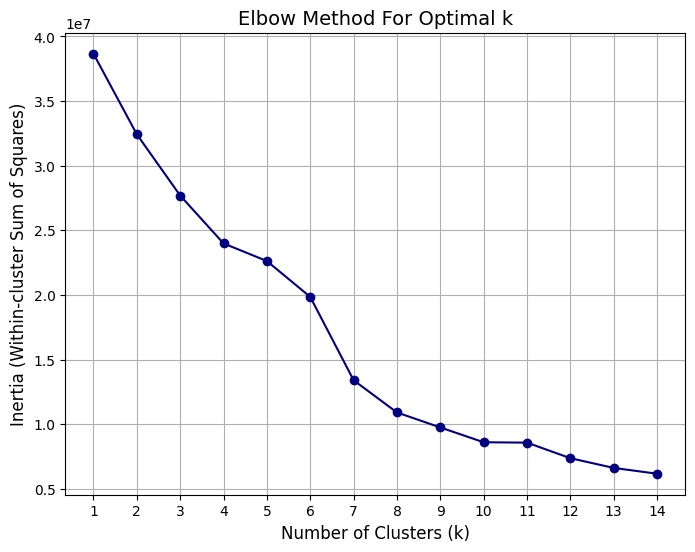

In [ ]:
# Elbow Method to find optimal K
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'o-', color='navy')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method For Optimal k', fontsize=14)
plt.xticks(K_range)
plt.grid(True)
plt.show()

sum of squares distances between different points within a cluster vs no of clusters

<h3>6 clusters would be better based on the elbow graph</h3>

In [ ]:
def category_price_clustering(df, n_clusters=6):
    results = []

    for category in df['sub_category_encoded'].unique():
        cat_df = df[df['sub_category_encoded'] == category].copy()

        X = cat_df[features].dropna()

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cat_df.loc[X.index, 'price_cluster'] = kmeans.fit_predict(X_scaled)

        results.append(cat_df)

    clustered_df = pd.concat(results)
    return clustered_df

clustered_data = category_price_clustering(df)

<ipython-input-51-56013f22b276>:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


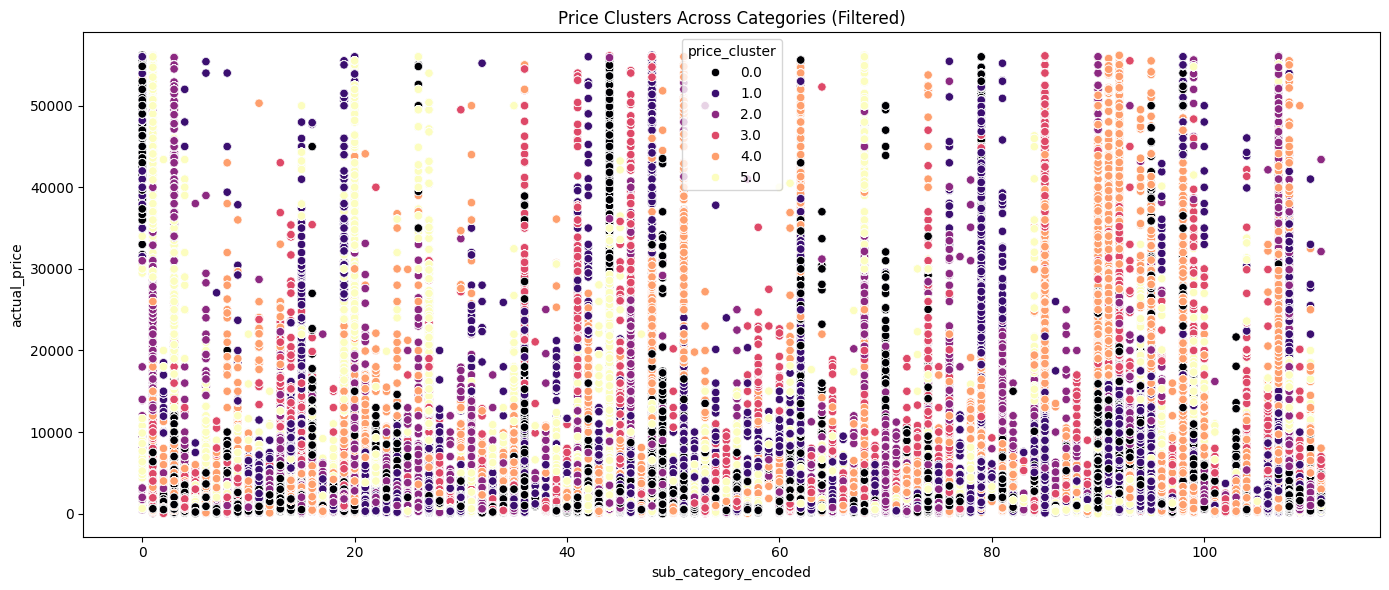

In [ ]:
# Remove extreme outliers (e.g., discount_price > 99th percentile)
q99 = clustered_data['actual_price'].quantile(0.99)
filtered_data = clustered_data[clustered_data['actual_price'] <= q99]

plt.figure(figsize=(14, 6))
sns.scatterplot(data=filtered_data, x='sub_category_encoded', y='actual_price', hue='price_cluster', palette='magma')
plt.title('Price Clusters Across Categories (Filtered)')
plt.tight_layout()
plt.show()


Low-price clusters (e.g., 0, 1) can tolerate smaller discounts — their demand might be price-inelastic.

Higher-price clusters (e.g., 4, 5) could be prime candidates for promotions, especially in categories where competition is high.

In [ ]:
cluster_avg_prices = clustered_data.groupby('price_cluster')['actual_price'].mean().sort_values()

print("Average Discount Price by Cluster:\n")
print(cluster_avg_prices)

Average Discount Price by Cluster:

price_cluster
0.0      3519.299627
2.0      3544.832705
1.0      5013.603300
5.0      5257.114957
4.0      6815.682186
3.0    122042.640299
Name: actual_price, dtype: float64


<b>Low clusters: 0, 1, 4</b> can tolerate smaller discounts — their demand might be price-inelastic.

<b>Mid clusters: 2, 3</b> can tolerate smaller discounts or high discounts can be used as price ladders

<b>High cluster: 5</b> could be prime candidates for promotions, especially in categories where competition is high.

Based on the average discount price of that cluster we categorize the clusters

In [ ]:
def generate_cluster_summary(df):
    summary = []

    for subcat in df['sub_category_encoded'].unique():
        sub_df = df[df['sub_category_encoded'] == subcat]

        dominant_cluster = sub_df['price_cluster'].mode().iloc[0]

        avg_price = sub_df['actual_price'].mean()
        min_price = sub_df['actual_price'].min()
        max_price = sub_df['actual_price'].max()

        p75 = df['actual_price'].quantile(0.75)
        p25 = df['actual_price'].quantile(0.25)

        if dominant_cluster in [0, 1, 5] and avg_price < p25:
            suggestion = "Minimal"
        elif dominant_cluster in [2, 4] or avg_price < p75:
            suggestion = "Moderate"
        else:
            suggestion = "Higher discount"



        summary.append({
            "sub_category_encoded": subcat,
            "dominant_cluster": dominant_cluster,
            "avg_price": round(avg_price, 2),
            "min_price": round(min_price, 2),
            "max_price": round(max_price, 2),
            "discount_suggestion": suggestion
        })

    summary_df = pd.DataFrame(summary)
    return summary_df

Dominant cluster is in any of the low clusters and average discount price of that sub category is within the 25th quartile - <b>Minimal discount</b>

Dominant cluster is in any of the mid clusters and average discount price of that sub category is within the 75th quartile - <b>Moderate discount</b>

Dominant cluster is in any of the high clusters and average discount price of that sub category is above the 75th quartile - <b>High discount</b>

<b>Dominant Cluster - </b>most repeated cluster within a sub category

In [ ]:
summary_df = generate_cluster_summary(clustered_data)

In [ ]:
summary_df = summary_df.merge(df[['sub_category_encoded', 'sub_category']].drop_duplicates(), on='sub_category_encoded')
summary_df

,sub_category_encoded,dominant_cluster,avg_price,min_price,max_price,discount_suggestion,sub_category
0,0,0.0,54790.17,499.0,149000.0,Higher discount,Air Conditioners
1,1,3.0,5794.44,59.0,158490.0,Higher discount,All Appliances
2,2,0.0,1582.68,33.0,43399.0,Moderate,All Car & Motorbike Products
3,3,0.0,4974.00,20.0,161999.0,Higher discount,All Electronics
4,4,3.0,2232.32,59.0,62480.0,Moderate,All Exercise & Fitness
...,...,...,...,...,...,...,...
107,107,4.0,19823.39,180.0,600000.0,Moderate,Washing Machines
108,108,0.0,4076.44,139.0,113750.0,Higher discount,Watches
109,109,2.0,1632.46,90.0,49999.0,Moderate,Western Wear
110,110,2.0,2234.48,99.0,70522.1,Moderate,Women's Fashion


Cheap products don’t need much discount — they’re already affordable.

Mid-range products are often competitive and can benefit from a moderate boost.

Expensive products need heavier discounts to attract budget-sensitive buyers or drive volume.

<h2>LSTM(Didn't work)</h2>

In [ ]:
weeks_per_year = 52
df['week_index'] = np.floor(df.index / 1000).astype(int)

# Wrap around after 52 weeks, keeps date in 2023
df['date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(df['week_index'] % weeks_per_year, unit='W')

In [ ]:
# ggregate: Weekly demand = count of interactions per product
weekly_demand = df.groupby([
    pd.Grouper(key='date', freq='W'),
    'productId'
]).agg({
    'productId': 'count'
}).rename(columns={'productId': 'weekly_demand'}).reset_index()

In [ ]:
# Create full date-product matrix (to fill missing weeks with 0 demand)
products = df['productId'].unique()
weeks = pd.date_range(start='2023-01-01', end='2023-12-31', freq='W')
full_index = pd.MultiIndex.from_product([weeks, products], names=['date', 'productId'])
full_df = pd.DataFrame(index=full_index).reset_index()

In [ ]:
full_df.isna().sum()

,0
date,0
productId,0


In [ ]:
# Merge and fill missing weeks
merged = pd.merge(full_df, weekly_demand, on=['date', 'productId'], how='left')
merged['weekly_demand'] = merged['weekly_demand'].fillna(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale demand
scaler = MinMaxScaler()
merged['weekly_demand_scaled'] = scaler.fit_transform(merged[['weekly_demand']])

In [ ]:
df = df.sort_values(['productId', 'date'])  # super important for groupby performance

In [ ]:
def create_sequences_grouped(df, product_col='productId', target_col='weekly_demand_scaled', seq_length=4):
    X, y = [], []
    for _, group in df.groupby(product_col):
        values = group.sort_values('date')[target_col].values
        for i in range(len(values) - seq_length):
            X.append(values[i:i+seq_length])
            y.append(values[i+seq_length])
    return np.array(X), np.array(y)


In [ ]:
X, y = create_sequences_grouped(merged)

#Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Saving weights
checkpoint = ModelCheckpoint(
    filepath='model_weights_epoch_{epoch:02d}.weights.h5',  # save file with epoch number
    save_weights_only=True,    # only save weights, not full model
    save_freq='epoch',         # after every epoch
    verbose=1                  # print when saving
)

In [ ]:
#LSTM
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[checkpoint])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
388286/388286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1282e-06
Epoch 1: saving model to model_weights_epoch_01.weights.h5
388286/388286 ━━━━━━━━━━━━━━━━━━━━ 857s 2ms/step - loss: 6.1282e-06 - val_loss: 5.1360e-06
Epoch 2/5
388263/388286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4267e-06
Epoch 2: saving model to model_weights_epoch_02.weights.h5
388286/388286 ━━━━━━━━━━━━━━━━━━━━ 855s 2ms/step - loss: 5.4267e-06 - val_loss: 5.1341e-06
Epoch 3/5
388286/388286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4773e-06
Epoch 3: saving model to model_weights_epoch_03.weights.h5
388286/388286 ━━━━━━━━━━━━━━━━━━━━ 857s 2ms/step - loss: 5.4773e-06 - val_loss: 5.1148e-06
Epoch 4/5
388274/388286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5067e-06
Epoch 4: saving model to model_weights_epoch_04.weights.h5
388286/388286 ━━━━━━━━━━━━━━━━━━━━ 854s 2ms/step - loss: 5.5067e-06 - val_loss: 5.1333e-06
Epoch 5/5
388275/388286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5818e-06
Epoch 5: saving mode

In [ ]:
evaluation = model.evaluate(X_test, y_test)

121340/121340 ━━━━━━━━━━━━━━━━━━━━ 192s 2ms/step - loss: 5.4691e-06


In [ ]:
evaluation

5.274556770018535e-06

In [ ]:
# Predict the demand
y_pred = model.predict(X_test)

121340/121340 ━━━━━━━━━━━━━━━━━━━━ 138s 1ms/step


In [ ]:
#Used min max scaler so inveverse scaling it
y_pred_original = scaler.inverse_transform(y_pred)
y_pred_original

array([[0.535043],
       [0.535043],
       [0.535043],
       ...,
       [0.535043],
       [0.535043],
       [0.535043]], dtype=float32)

In [ ]:
df

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,main_category_encoded,sub_category_encoded,productId,random_number_userId,userId,weighted_rating,rating_category,price_category,relative_discount,category_rating_avg,uniqueness_score,week_index,date
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,10,1,4.181457,High,High,5.438494,3.821249,0.000114,0,2023-01-01
1,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,10,2,4.181457,High,High,5.438494,3.821249,0.000114,0,2023-01-01
2,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,10,3,4.181457,High,High,5.438494,3.821249,0.000114,0,2023-01-01
3,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,10,4,4.181457,High,High,5.438494,3.821249,0.000114,0,2023-01-01
4,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,1,0,1,10,5,4.181457,High,High,5.438494,3.821249,0.000114,0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6446394,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,5,1,1.533333,Low,High,0.574952,3.779807,0.000074,6446,2023-12-17
6446395,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,5,2,1.533333,Low,High,0.574952,3.779807,0.000074,6446,2023-12-17
6446396,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,5,3,1.533333,Low,High,0.574952,3.779807,0.000074,6446,2023-12-17
6446397,Mothercare Printed Cotton Elastane Girls Infan...,sports & fitness,Yoga,4.6,5.0,1039.0,1299.0,14,111,396210,5,4,1.533333,Low,High,0.574952,3.779807,0.000074,6446,2023-12-17


In [ ]:
full_df

,date,productId
0,2023-01-01,1
1,2023-01-01,2
2,2023-01-01,3
3,2023-01-01,4
4,2023-01-01,5
...,...,...
20999125,2023-12-31,396206
20999126,2023-12-31,396207
20999127,2023-12-31,396208
20999128,2023-12-31,396209


In [ ]:
merged

,date,productId,weekly_demand,weekly_demand_scaled
0,2023-01-01,1,10.0,0.010
1,2023-01-01,2,10.0,0.010
2,2023-01-01,3,7.0,0.007
3,2023-01-01,4,12.0,0.012
4,2023-01-01,5,10.0,0.010
...,...,...,...,...
20999125,2023-12-31,396206,0.0,0.000
20999126,2023-12-31,396207,0.0,0.000
20999127,2023-12-31,396208,0.0,0.000
20999128,2023-12-31,396209,0.0,0.000


In [ ]:
merged['weekly_demand'].isin([0]).sum()

np.int64(20496484)

In [ ]:
df_lstm = df[['productId','date']]
df_lstm

,productId,date
0,1,2023-01-01
1,1,2023-01-01
2,1,2023-01-01
3,1,2023-01-01
4,1,2023-01-01
...,...,...
6443809,396210,2023-11-26
6443810,396210,2023-11-26
6443811,396210,2023-11-26
6443812,396210,2023-11-26


In [ ]:
df_lstm = df_lstm.sort_values(by=['productId', 'date'])
df_lstm

,productId,date
0,1,2023-01-01
1,1,2023-01-01
2,1,2023-01-01
3,1,2023-01-01
4,1,2023-01-01
...,...,...
6443809,396210,2023-11-26
6443810,396210,2023-11-26
6443811,396210,2023-11-26
6443812,396210,2023-11-26


In [ ]:
# 1. Group by product_id and date_of_purchase
grouped = df_lstm.groupby(['productId', 'date']).size().reset_index(name='daily_demand')

In [ ]:
grouped

,productId,date,daily_demand
0,1,2023-01-01,5
1,1,2023-03-05,6
2,1,2023-04-09,14
3,1,2023-05-07,13
4,1,2023-11-26,8
...,...,...,...
502758,396206,2023-11-26,11
502759,396207,2023-11-26,20
502760,396208,2023-11-26,8
502761,396209,2023-11-26,18


In [ ]:
# First, create a full date range
full_dates = pd.date_range(df_lstm['date'].min(), df_lstm['date'].max())

# Create a dataframe with all combinations of productId and date
product_dates = (
    df_lstm['productId']
    .drop_duplicates()
    .to_frame()
    .assign(key=1)
    .merge(pd.DataFrame({'date': full_dates, 'key': 1}), on='key')
    .drop('key', axis=1)
)

# Now group original to get daily demand
grouped = df_lstm.groupby(['productId', 'date']).size().reset_index(name='daily_demand')

# Merge full product-date pairs with grouped demand
final = product_dates.merge(grouped, on=['productId', 'date'], how='left')

# Fill missing demand with 0
final['daily_demand'].fillna(0, inplace=True)

# Optionally, convert daily_demand to int
final['daily_demand'] = final['daily_demand'].astype(int)


<ipython-input-39-f64f1f1698a7>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final['daily_demand'].fillna(0, inplace=True)


In [ ]:
final

,productId,date,daily_demand
0,1,2023-01-01,5
1,1,2023-01-02,0
2,1,2023-01-03,0
3,1,2023-01-04,0
4,1,2023-01-05,0
...,...,...,...
141843175,396210,2023-12-20,0
141843176,396210,2023-12-21,0
141843177,396210,2023-12-22,0
141843178,396210,2023-12-23,0


In [ ]:
full_dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-12-15', '2023-12-16', '2023-12-17', '2023-12-18',
               '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22',
               '2023-12-23', '2023-12-24'],
              dtype='datetime64[ns]', length=358, freq='D')